# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(ggplot2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The followin

In [2]:
remove_cols= function(l, cols){
    return(l[! l %in% cols])
}

In [3]:
make_factors = function(model_data){
model_data$Structure1 = as.factor(model_data$Structure1)
model_data$Pipe_Geome = as.factor(model_data$Pipe_Geome)
model_data$Pipe_Mater = as.factor(model_data$Pipe_Mater)
model_data$Condition = as.factor(model_data$Condition)
return(model_data)
}

In [4]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- "C:/Users/Jeff/Google Drive/research/Sadler_3rdPaper_Data/"
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [5]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [6]:
test_df = dbReadTable(con, 'test_geog_data_hg')
train_df = dbReadTable(con, 'train_geog_data_hg')

In [7]:
colnames(test_df)


[1] "level_0"      "AWDR.19"      "AWND.19"      "AWND.20"      "WDF2.19"     
  [6] "WDF2.20"      "WDF2.3"       "WDF6.18"      "WGF6.18"      "WSF2.19"     
 [11] "WSF2.20"      "WSF2.3"       "WSF6.18"      "event_name"   "flooded"     
 [16] "gw_av.10"     "gw_av.11"     "gw_av.4"      "gw_av.5"      "gw_av.6"     
 [21] "gw_av.8"      "gw_av.9"      "hht.17"       "hht.18"       "ht.17"       
 [26] "ht.18"        "llt.17"       "llt.18"       "lt.17"        "lt.18"       
 [31] "num_flooded"  "r15.11_td.17" "r15.11_td.18" "r15.12_td.17" "r15.12_td.18"
 [36] "r15.13_td.17" "r15.13_td.18" "r15.14_td.17" "r15.14_td.18" "r15.15_td.17"
 [41] "r15.15_td.18" "r15.16_td.17" "r15.16_td.18" "r15.1_td.17"  "r15.1_td.18" 
 [46] "r15.21_td.17" "r15.21_td.18" "r15.2_td.17"  "r15.2_td.18"  "r15.7_td.17" 
 [51] "r15.7_td.18"  "r15mx.1"      "r15mx.11"     "r15mx.12"     "r15mx.13"    
 [56] "r15mx.14"     "r15mx.15"     "r15mx.16"     "r15mx.2"      "r15mx.21"    
 [61] "r15mx.7"      "r3d.1"        "r3d.11"       "r3d.12"       "r3d.13"      
 [66] "r3d.14"       "r3d.15"       "r3d.16"       "r3d.19"       "r3d.2"       
 [71] "r3d.20"       "r3d.21"       "r3d.7"        "rd.1"         "rd.11"       
 [76] "rd.12"        "rd.13"        "rd.14"        "rd.15"        "rd.16"       
 [81] "rd.19"        "rd.2"         "rd.20"        "rd.21"        "rd.7"        
 [86] "rhr.11_td.17" "rhr.11_td.18" "rhr.12_td.17" "rhr.12_td.18" "rhr.13_td.17"
 [91] "rhr.13_td.18" "rhr.14_td.17" "rhr.14_td.18" "rhr.15_td.17" "rhr.15_td.18"
 [96] "rhr.16_td.17" "rhr.16_td.18" "rhr.1_td.17"  "rhr.1_td.18"  "rhr.21_td.17"
[101] "rhr.21_td.18" "rhr.2_td.17"  "rhr.2_td.18"  "rhr.7_td.17"  "rhr.7_td.18" 
[106] "rhrmx.1"      "rhrmx.11"     "rhrmx.12"     "rhrmx.13"     "rhrmx.14"    
[111] "rhrmx.15"     "rhrmx.16"     "rhrmx.2"      "rhrmx.21"     "rhrmx.7"     
[116] "td_av.17"     "td_av.18"     "index"        "location"     "xcoord"      
[121] "ycoord"       "count"        "twi"          "elev_1"       "dist_to_ba"  
[126] "imp"          "dist_to_wa"   "is_dntn"      "in_hague"     "Structure1"  
[131] "Rim_Elevat"   "Invert_Ele"   "Year_Insta"   "Pipe_Geome"   "Horizontal"  
[136] "Vertical_D"   "Pipe_Lengt"   "Pipe_Mater"   "Year_Ins_1"   "Condition"   
[141] "flood_pt"

In [20]:
cols_to_remove = c('level_0', 'index', 'is_dntn', 'flood_pt', 'event_name', 'num_flooded', 'location', 'count', 'flooded', 'in_hague')
in_col_names = remove_cols(colnames(test_df), cols_to_remove)
out_col_name = 'flooded'

In [9]:
test_df = make_factors(test_df)
train_df = make_factors(train_df)

In [10]:
train_data = train_df[, append(in_col_names, out_col_name)]
test_data = test_df[, append(in_col_names, out_col_name)]

In [11]:
train_in_data = train_df[, in_col_names]
test_in_data = test_df[, in_col_names]

In [12]:
tst_out = test_df[, out_col_name]
trn_out = train_df[, out_col_name]

### Decision Trees

In [13]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))

In [14]:
colnames(train_data)

[1] "AWDR.19"      "AWND.19"      "AWND.20"      "WDF2.19"      "WDF2.20"     
  [6] "WDF2.3"       "WDF6.18"      "WGF6.18"      "WSF2.19"      "WSF2.20"     
 [11] "WSF2.3"       "WSF6.18"      "gw_av.10"     "gw_av.11"     "gw_av.4"     
 [16] "gw_av.5"      "gw_av.6"      "gw_av.8"      "gw_av.9"      "hht.17"      
 [21] "hht.18"       "ht.17"        "ht.18"        "llt.17"       "llt.18"      
 [26] "lt.17"        "lt.18"        "r15.11_td.17" "r15.11_td.18" "r15.12_td.17"
 [31] "r15.12_td.18" "r15.13_td.17" "r15.13_td.18" "r15.14_td.17" "r15.14_td.18"
 [36] "r15.15_td.17" "r15.15_td.18" "r15.16_td.17" "r15.16_td.18" "r15.1_td.17" 
 [41] "r15.1_td.18"  "r15.21_td.17" "r15.21_td.18" "r15.2_td.17"  "r15.2_td.18" 
 [46] "r15.7_td.17"  "r15.7_td.18"  "r15mx.1"      "r15mx.11"     "r15mx.12"    
 [51] "r15mx.13"     "r15mx.14"     "r15mx.15"     "r15mx.16"     "r15mx.2"     
 [56] "r15mx.21"     "r15mx.7"      "r3d.1"        "r3d.11"       "r3d.12"      
 [61] "r3d.13"       "r3d.14"       "r3d.15"       "r3d.16"       "r3d.19"      
 [66] "r3d.2"        "r3d.20"       "r3d.21"       "r3d.7"        "rd.1"        
 [71] "rd.11"        "rd.12"        "rd.13"        "rd.14"        "rd.15"       
 [76] "rd.16"        "rd.19"        "rd.2"         "rd.20"        "rd.21"       
 [81] "rd.7"         "rhr.11_td.17" "rhr.11_td.18" "rhr.12_td.17" "rhr.12_td.18"
 [86] "rhr.13_td.17" "rhr.13_td.18" "rhr.14_td.17" "rhr.14_td.18" "rhr.15_td.17"
 [91] "rhr.15_td.18" "rhr.16_td.17" "rhr.16_td.18" "rhr.1_td.17"  "rhr.1_td.18" 
 [96] "rhr.21_td.17" "rhr.21_td.18" "rhr.2_td.17"  "rhr.2_td.18"  "rhr.7_td.17" 
[101] "rhr.7_td.18"  "rhrmx.1"      "rhrmx.11"     "rhrmx.12"     "rhrmx.13"    
[106] "rhrmx.14"     "rhrmx.15"     "rhrmx.16"     "rhrmx.2"      "rhrmx.21"    
[111] "rhrmx.7"      "td_av.17"     "td_av.18"     "xcoord"       "ycoord"      
[116] "twi"          "elev_1"       "dist_to_ba"   "imp"          "dist_to_wa"  
[121] "in_hague"     "Structure1"   "Rim_Elevat"   "Invert_Ele"   "Year_Insta"  
[126] "Pipe_Geome"   "Horizontal"   "Vertical_D"   "Pipe_Lengt"   "Pipe_Mater"  
[131] "Year_Ins_1"   "Condition"    "flooded"

In [15]:
fit = rpart(dt_fmla, method='class', data=train_data, minsplit=1, minbucket=1)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = train_data, method = "class", 
    minsplit = 1, minbucket = 1)

Variables actually used in tree construction:
 [1] AWDR.19      gw_av.8      r15.1_td.17  r15.11_td.17 r3d.14      
 [6] rd.1         rd.11        rd.15        rd.2         rd.20       
[11] rhrmx.2      rhrmx.21    

Root node error: 73/17946 = 0.0040678

n= 17946 

        CP nsplit rel error  xerror     xstd
1 0.239726      0  1.000000 1.00000 0.116803
2 0.044521      2  0.520548 0.54795 0.086541
3 0.027397      9  0.191781 0.27397 0.061228
4 0.020548     10  0.164384 0.26027 0.059679
5 0.010000     16  0.041096 0.16438 0.047438


png 
  2

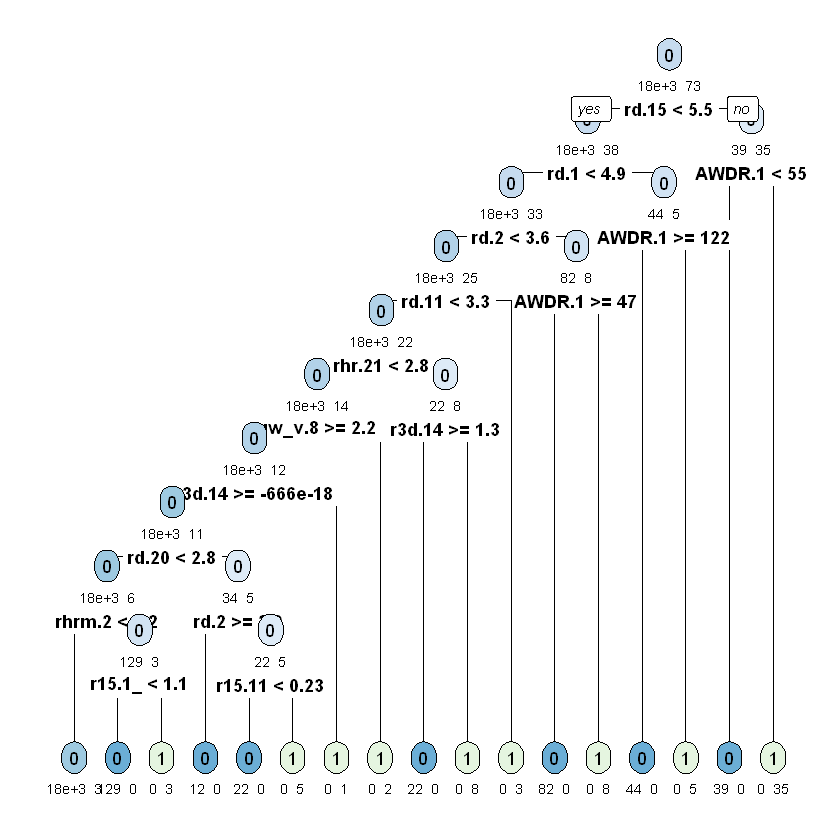

In [16]:
tiff(paste(fig_dir, "Plot_hg.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

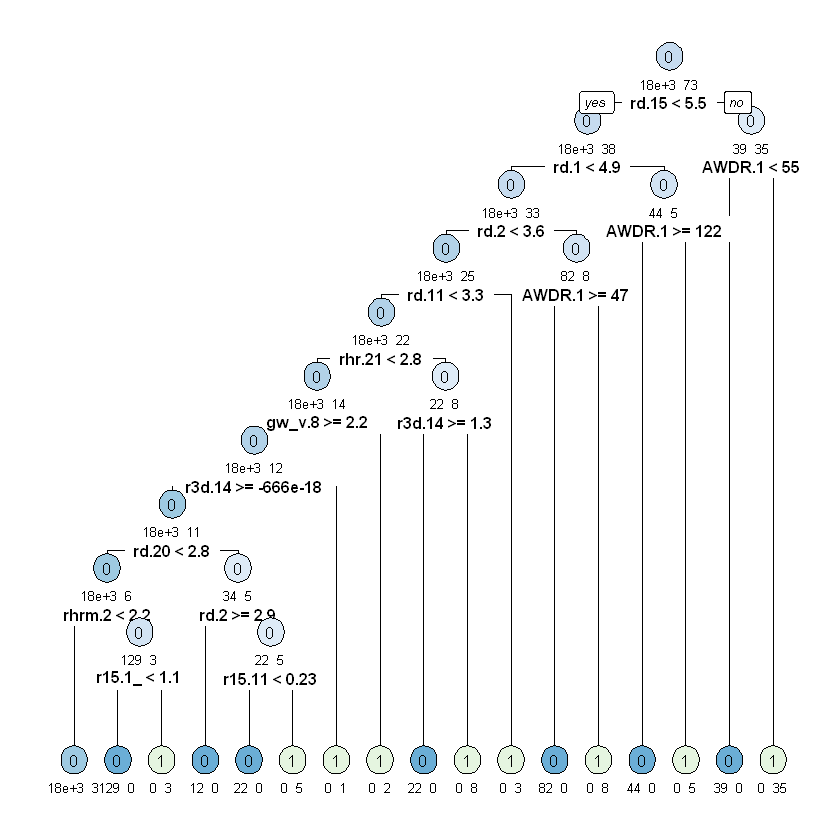

In [17]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.8, extra=1, varlen = 6)

#### Decision Tree training results

In [18]:
pred = predict(pfit, train_data, type = 'class')
table(trn_out, pred)

       pred
trn_out     0     1
      0 17873     0
      1     3    70

#### Decision Tree testing results

In [19]:
pred = predict(pfit, test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out    0    1
      0 7661    0
      1    3   28